# IBKR QQQ Backtest for RSI + MA9 + MA18 + Bollinger Bands Signal

For more close to real trading, I replace the Moving average signal with k-1

Including: 
1. Both Long and Short Side
2. Bollinger Band Confirmation
3. Trailing Stop
4. Relative Strength Index
4. Stock: QQQ
5. Length: 30

In [1]:
from ib_insync import *
import pandas as pd
import matplotlib.pyplot as plt
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=10)

Error 321, reqId -1: Error validating request.-'cr' : cause - The API interface is currently in Read-Only mode.
Error 321, reqId -1: Error validating request.-'b2' : cause - The API interface is currently in Read-Only mode.
open orders request timed out
completed orders request timed out


<IB connected to 127.0.0.1:7497 clientId=10>

In [2]:
contract = Stock('COIN', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)
all_data = []
for offset in range(60):
    end_time = pd.Timestamp.now() - pd.Timedelta(days=offset)
    bars = ib.reqHistoricalData(
        contract,
        endDateTime=end_time.strftime('%Y%m%d %H:%M:%S'),
        durationStr='1 D',
        barSizeSetting='1 min',
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    all_data.extend(bars)
df = util.df(all_data).sort_values('date').drop_duplicates().reset_index(drop=True)
df = df[df['volume'] > 0]

In [3]:
df['MA21'] = df['close'].rolling(21).mean()
df['UpperBB'] = df['MA21'] + 2 * df['close'].rolling(21).std()
df['LowerBB'] = df['MA21'] - 2 * df['close'].rolling(21).std()
df['RSI'] = df['close'].diff().apply(lambda x: max(x, 0)).rolling(14).mean() / \
             df['close'].diff().abs().rolling(14).mean() * 100
df.dropna(inplace=True)

In [4]:
position = None
entry_price = 0
trailing_stop = 0
side = None
results = []

for i in range(1, len(df)):
    prev = df.iloc[i - 1]
    row = df.iloc[i]
    price = row['close']
    rsi = prev['RSI']
    upper = prev['UpperBB']
    lower = prev['LowerBB']

    if position is None and rsi < 55 and prev['close'] <= lower * 1.01:
        position = price
        entry_time = row['date']
        trailing_stop = price * 0.96
        side = 'long'
        continue
    elif position is None and rsi > 60 and prev['close'] >= upper * 0.99:
        position = price
        entry_time = row['date']
        trailing_stop = price * 1.04
        side = 'short'
        continue

    if position is not None:
        if side == 'long':
            trailing_stop = max(trailing_stop, price * 0.96)
            if rsi > 58 or price < trailing_stop:
                gain_pct = (price - position) / position * 100
                results.append({
                    'Entry Time': entry_time,
                    'Exit Time': row['date'],
                    'Side': 'Long',
                    'Entry Price': position,
                    'Exit Price': price,
                    'PnL%': gain_pct
                })
                position = None
        elif side == 'short':
            trailing_stop = min(trailing_stop, price * 1.04)
            if rsi < 58 or price > trailing_stop:
                gain_pct = (position - price) / position * 100
                results.append({
                    'Entry Time': entry_time,
                    'Exit Time': row['date'],
                    'Side': 'Short',
                    'Entry Price': position,
                    'Exit Price': price,
                    'PnL%': gain_pct
                })
                position = None

Total Transaction Times: 572
Average Return per Transaction: 0.01 %
Accumulated Return: 6.53 %
Win Rate: 60.14 %


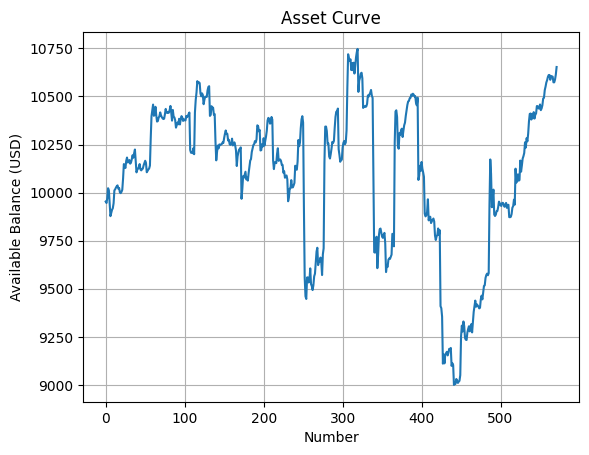

Balance: $10653.24


In [5]:
initial_capital = 10000
result_df = pd.DataFrame(results)
if not result_df.empty:
    print('Total Transaction Times:', len(result_df))
    print('Average Return per Transaction:', round(result_df['PnL%'].mean(), 2), '%')
    print('Accumulated Return:', round(result_df['PnL%'].sum(), 2), '%')
    wins = result_df[result_df['PnL%'] > 0]
    win_rate = len(wins) / len(result_df) * 100
    print('Win Rate:', round(win_rate, 2), '%')
    
    result_df['Equity'] = initial_capital * (1 + result_df['PnL%'].cumsum() / 100)
    result_df['Equity'].plot(title='Asset Curve')
    plt.xlabel('Number')
    plt.ylabel('Available Balance (USD)')
    plt.grid(True)
    plt.show()
    
    print('Balance: ${}'.format(round(result_df['Equity'].iloc[-1], 2)))
else:
    print('No Signal')

In [6]:
ib.disconnect()